**Task:** predict whether the client will leave the bank in the near future or not. You are provided with historical data on customer behavior and termination of agreements with the bank.

## Data preparation

### Loading and initial analysis

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from seaborn import pairplot
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.metrics  import f1_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import warnings
warnings.simplefilter(action='ignore', category=Warning)


In [2]:
df = pd.read_csv('datasets/Churn.csv')

In [3]:
display(df.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
display(df.describe())

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Data preprocessing

1. Extra columns
2. Name of columns
3. Missing data in Tenure
4. Category data (Geography, Gender)

RowNumber - row index in data
CustomerId - unique customer identifier
Surname - surname
CreditScore - credit rating
Geography - country of residence
gender
Age - age
Tenure - how many years a person has been a bank client
Balance - account balance
NumOfProducts - the number of bank products used by the client
HasCrCard - the presence of a credit card
IsActiveMember - client activity
EstimatedSalary - estimated salary

#### 1 **Droping columns**

Let's check surnames. Maybe there is only s few of them so they could be used as additional factors (very unlikely)

In [5]:
df.groupby(['Surname'])['RowNumber'].count().sort_values(ascending=False).head(10)

Surname
Smith       32
Martin      29
Scott       29
Walker      28
Brown       26
Shih        25
Genovese    25
Yeh         25
Wright      24
Maclean     24
Name: RowNumber, dtype: int64

In [6]:
df.groupby(['CustomerId'])['RowNumber'].count().sort_values(ascending=False).head(10)

CustomerId
15565701    1
15732281    1
15732199    1
15732202    1
15732235    1
15732265    1
15732266    1
15732268    1
15732270    1
15732293    1
Name: RowNumber, dtype: int64

RowNumber, CustomerId, Surname - there is no point in them. 1 duplicates index, 2 and 3 are too unique

In [7]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### **2. Add missing values to Tenure**

In [8]:
df.groupby(['Tenure'])['CreditScore'].count().sort_values(ascending=False)

Tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: CreditScore, dtype: int64

In [9]:
df.query('Tenure.isnull()').head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


In [10]:
df.query('Tenure == Tenure').describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938
std,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000
50%,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000
75%,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [11]:
df.query('Tenure.isnull()').describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


On the one hand, people who do not have data are almost the same, but I don’t want to throw column away. The easiest option so far is to fill in with the median - 5

In [12]:
df.corrwith(df['Tenure'])

CreditScore       -0.000062
Age               -0.013134
Tenure             1.000000
Balance           -0.007911
NumOfProducts      0.011979
HasCrCard          0.027232
IsActiveMember    -0.032178
EstimatedSalary    0.010520
Exited            -0.016761
dtype: float64

It doesn't correlate with other indicators, so we can't use them to distinguish Tenure

In [13]:
print(df.query('Gender == "Female"')['Tenure'].mean())
print(df.query('Gender == "Male"')['Tenure'].mean())
print(df.query('Geography == "Spain"')['Tenure'].mean())
print(df.query('Geography == "France"')['Tenure'].mean())
print(df.query('Geography == "Germany"')['Tenure'].mean())

4.957493320378917
5.030960997185364
5.001779359430605
5.003956043956044
4.981247274313127


In [14]:
df['Tenure'] = df['Tenure'].fillna(5)

In [15]:
df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


#### **3. Convert gender and country** 

In [16]:
df.groupby('Gender')['CreditScore'].count()

Gender
Female    4543
Male      5457
Name: CreditScore, dtype: int64

In [17]:
df.groupby('Geography')['CreditScore'].count()

Geography
France     5014
Germany    2509
Spain      2477
Name: CreditScore, dtype: int64

In [18]:
encoder = OrdinalEncoder()
df['Gender'] = encoder.fit_transform(df[['Gender']])

In [19]:
df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0.0,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,0.0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,0.0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,0.0,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,0.0,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,1.0,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,1.0,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,0.0,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,1.0,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,1.0,27,2.0,134603.88,1,1,1,71725.73,0


In [20]:
df1 = df.copy(deep=True)
df1[['Germany', 'Spain']] = pd.get_dummies(df['Geography'],drop_first=True)
df1 = df1.drop('Geography', axis=1)
df1.head(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain
0,619,0.0,42,2.0,0.00,1,1,1,101348.88,1,0,0
1,608,0.0,41,1.0,83807.86,1,0,1,112542.58,0,0,1
2,502,0.0,42,8.0,159660.80,3,1,0,113931.57,1,0,0
3,699,0.0,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,0.0,43,2.0,125510.82,1,1,1,79084.10,0,0,1
5,645,1.0,44,8.0,113755.78,2,1,0,149756.71,1,0,1
6,822,1.0,50,7.0,0.00,2,1,1,10062.80,0,0,0
7,376,0.0,29,4.0,115046.74,4,1,0,119346.88,1,1,0
8,501,1.0,44,4.0,142051.07,2,0,1,74940.50,0,0,0
9,684,1.0,27,2.0,134603.88,1,1,1,71725.73,0,0,0


In [21]:
pd.get_dummies(df['Geography'])
x = pd.get_dummies(df['Geography'],drop_first=True)
x

,Germany,Spain
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1
...,...,...
9995,0,0
9996,0,0
9997,0,0
9998,1,0


In [22]:
df = df.merge(x, left_index=True, right_index=True)
df = df.drop('Geography', axis=1)

**4. Renaming column names**

In [23]:
x = df.columns
x.str.lower()

Index(['creditscore', 'gender', 'age', 'tenure', 'balance', 'numofproducts',
       'hascrcard', 'isactivemember', 'estimatedsalary', 'exited', 'germany',
       'spain'],
      dtype='object')

In [24]:
x=['credit_score', 'gender', 'age', 'tenure', 'balance',
       'num_products', 'has_card', 'is_active', 'est_salary',
       'exited', 'germany', 'spain']

In [25]:
df.columns = x
df

,credit_score,gender,age,tenure,balance,num_products,has_card,is_active,est_salary,exited,germany,spain
0,619,0.0,42,2.0,0.00,1,1,1,101348.88,1,0,0
1,608,0.0,41,1.0,83807.86,1,0,1,112542.58,0,0,1
2,502,0.0,42,8.0,159660.80,3,1,0,113931.57,1,0,0
3,699,0.0,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,0.0,43,2.0,125510.82,1,1,1,79084.10,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1.0,39,5.0,0.00,2,1,0,96270.64,0,0,0
9996,516,1.0,35,10.0,57369.61,1,1,1,101699.77,0,0,0
9997,709,0.0,36,7.0,0.00,1,0,1,42085.58,1,0,0
9998,772,1.0,42,3.0,75075.31,2,1,0,92888.52,1,1,0


**5. Changing column data types**

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   credit_score  10000 non-null  int64  
 1   gender        10000 non-null  float64
 2   age           10000 non-null  int64  
 3   tenure        10000 non-null  float64
 4   balance       10000 non-null  float64
 5   num_products  10000 non-null  int64  
 6   has_card      10000 non-null  int64  
 7   is_active     10000 non-null  int64  
 8   est_salary    10000 non-null  float64
 9   exited        10000 non-null  int64  
 10  germany       10000 non-null  uint8  
 11  spain         10000 non-null  uint8  
dtypes: float64(4), int64(6), uint8(2)
memory usage: 800.9 KB


In [27]:
df['gender'] = df['gender'].astype('int64')
df['tenure'] = df['tenure'].astype('int64')
df['balance'] = (df['balance']*100).astype('int64')
df['est_salary'] = (df['est_salary']*100).astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   credit_score  10000 non-null  int64
 1   gender        10000 non-null  int64
 2   age           10000 non-null  int64
 3   tenure        10000 non-null  int64
 4   balance       10000 non-null  int64
 5   num_products  10000 non-null  int64
 6   has_card      10000 non-null  int64
 7   is_active     10000 non-null  int64
 8   est_salary    10000 non-null  int64
 9   exited        10000 non-null  int64
 10  germany       10000 non-null  uint8
 11  spain         10000 non-null  uint8
dtypes: int64(10), uint8(2)
memory usage: 800.9 KB


### Preprocessing results

**Description of new columns**
* credit_score — credit score
* gender - gender
* age - age
* tenure - how many years a person has been a client of the bank
* balance — account balance (*100 from initial!)
* num_products - the number of bank products used by the client
* has_card - the presence of a credit card
* is_active - client activity
* est_salary - estimated salary (*100 from the initial!)
* exited - the fact that the client left
* germany, spain- Country of residence (Germany, Spain or France (0.0))

**Conclusions**

1. Data loaded and explored
2. Excluded 3 columns
3. Missing data for Tenure was filled with median value 5
4. Countries and gender was converted (Germany, Spain - columns, France - (0,0) and gender (0 - f, 1 -m)
5. Column names changed - described above
6. All data is converted to int, for this, salary and balance * 100

## Models

### Initial model without treating imbalances

3 types of model - logistic, tree and random forest. 

For the last 2 we change the depth (number of trees)

results_tab - table for comparing initial results and after changing the selection

In [28]:
results_tab = pd.DataFrame()
results_tab = results_tab.reindex(columns = ('Model', 'Initial'))        

In [29]:
df.describe()

,credit_score,gender,age,tenure,balance,num_products,has_card,is_active,est_salary,exited,germany,spain
count,10000.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,4.99790,7.648589e+06,1.530200,0.70550,0.515100,1.000902e+07,0.203700,0.250900,0.247700
std,96.653299,0.497932,10.487806,2.76001,6.239740e+06,0.581654,0.45584,0.499797,5.751049e+06,0.402769,0.433553,0.431698
min,350.000000,0.000000,18.000000,0.00000,0.000000e+00,1.000000,0.00000,0.000000,1.158000e+03,0.000000,0.000000,0.000000
25%,584.000000,0.000000,32.000000,3.00000,0.000000e+00,1.000000,0.00000,0.000000,5.100211e+06,0.000000,0.000000,0.000000
50%,652.000000,1.000000,37.000000,5.00000,9.719854e+06,1.000000,1.00000,1.000000,1.001939e+07,0.000000,0.000000,0.000000
75%,718.000000,1.000000,44.000000,7.00000,1.276442e+07,2.000000,1.00000,1.000000,1.493882e+07,0.000000,1.000000,0.000000
max,850.000000,1.000000,92.000000,10.00000,2.508981e+07,4.000000,1.00000,1.000000,1.999925e+07,1.000000,1.000000,1.000000


In [30]:
df_train, df_valid = train_test_split(df, test_size=0.4, random_state=12345,
                                      stratify=df['exited']) 
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345,
                                     stratify=df_valid['exited']) 

In [31]:
display(df_train.describe())
display(df_test.describe())
display(df_valid.describe())

,credit_score,gender,age,tenure,balance,num_products,has_card,is_active,est_salary,exited,germany,spain
count,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,6000.000000,6000.000000,6000.000000,6.000000e+03,6000.000000,6000.000000,6000.00000
mean,649.949500,0.548500,38.999167,5.007667,7.634183e+06,1.527000,0.699500,0.515500,1.004040e+07,0.203667,0.248500,0.24900
std,97.034442,0.497684,10.491497,2.752127,6.259725e+06,0.576188,0.458514,0.499801,5.753686e+06,0.402757,0.432179,0.43247
min,350.000000,0.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,9.175000e+03,0.000000,0.000000,0.00000
25%,583.000000,0.000000,32.000000,3.000000,0.000000e+00,1.000000,0.000000,0.000000,5.085710e+06,0.000000,0.000000,0.00000
50%,651.000000,1.000000,37.000000,5.000000,9.732817e+06,1.000000,1.000000,1.000000,1.003843e+07,0.000000,0.000000,0.00000
75%,717.000000,1.000000,44.000000,7.000000,1.279981e+07,2.000000,1.000000,1.000000,1.502250e+07,0.000000,0.000000,0.00000
max,850.000000,1.000000,92.000000,10.000000,2.383876e+07,4.000000,1.000000,1.000000,1.999707e+07,1.000000,1.000000,1.00000


,credit_score,gender,age,tenure,balance,num_products,has_card,is_active,est_salary,exited,germany,spain
count,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000,2000.000000,2000.000000
mean,648.829000,0.546500,38.631000,4.934000,7.706920e+06,1.529500,0.718000,0.511500,1.010936e+07,0.203500,0.250500,0.240500
std,96.491254,0.497958,10.469606,2.774255,6.254002e+06,0.591866,0.450086,0.499993,5.764556e+06,0.402702,0.433409,0.427494
min,350.000000,0.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,1.230700e+04,0.000000,0.000000,0.000000
25%,583.000000,0.000000,32.000000,3.000000,0.000000e+00,1.000000,0.000000,0.000000,5.376774e+06,0.000000,0.000000,0.000000
50%,651.000000,1.000000,37.000000,5.000000,9.665379e+06,1.000000,1.000000,1.000000,1.012972e+07,0.000000,0.000000,0.000000
75%,715.000000,1.000000,44.000000,7.000000,1.276527e+07,2.000000,1.000000,1.000000,1.495360e+07,0.000000,1.000000,0.000000
max,850.000000,1.000000,84.000000,10.000000,2.215328e+07,4.000000,1.000000,1.000000,1.997277e+07,1.000000,1.000000,1.000000


,credit_score,gender,age,tenure,balance,num_products,has_card,is_active,est_salary,exited,germany,spain
count,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.00000,2000.000000,2000.000000,2.000000e+03,2000.00000,2000.00000,2000.000000
mean,653.966500,0.536500,38.980500,5.032500,7.633475e+06,1.54050,0.711000,0.517500,9.814565e+06,0.20400,0.25850,0.251000
std,95.630753,0.498791,10.495103,2.769707,6.167757e+06,0.58782,0.453411,0.499819,5.728020e+06,0.40307,0.43792,0.433697
min,350.000000,0.000000,18.000000,0.000000,0.000000e+00,1.00000,0.000000,0.000000,1.158000e+03,0.00000,0.00000,0.000000
25%,587.000000,0.000000,32.000000,3.000000,0.000000e+00,1.00000,0.000000,0.000000,4.755158e+06,0.00000,0.00000,0.000000
50%,655.000000,1.000000,37.000000,5.000000,9.733245e+06,1.00000,1.000000,1.000000,9.769648e+06,0.00000,0.00000,0.000000
75%,720.000000,1.000000,44.000000,7.000000,1.259074e+07,2.00000,1.000000,1.000000,1.461972e+07,0.00000,1.00000,1.000000
max,850.000000,1.000000,80.000000,10.000000,2.508981e+07,4.00000,1.000000,1.000000,1.999925e+07,1.00000,1.00000,1.000000


In [32]:
features_train = df_train.drop('exited', axis=1)
target_train = df_train['exited']
features_valid = df_valid.drop('exited', axis=1)
target_valid = df_valid['exited']
features_test = df_valid.drop('exited', axis=1)
target_test = df_valid['exited']
features_df = df.drop('exited', axis=1)
target_df = df['exited']

In [33]:
model = DecisionTreeClassifier(max_depth=2, random_state=12345)
model.fit(features_train, target_train)
valid_predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, valid_predictions) 
accuracy

0.835

[Text(418.5, 453.0, 'age <= 43.5\ngini = 0.324\nsamples = 6000\nvalue = [4778, 1222]\nclass = 0'),
 Text(209.25, 271.8, 'num_products <= 2.5\ngini = 0.219\nsamples = 4442\nvalue = [3887, 555]\nclass = 0'),
 Text(104.625, 90.59999999999997, 'gini = 0.197\nsamples = 4343\nvalue = [3862, 481]\nclass = 0'),
 Text(313.875, 90.59999999999997, 'gini = 0.378\nsamples = 99\nvalue = [25, 74]\nclass = 1'),
 Text(627.75, 271.8, 'is_active <= 0.5\ngini = 0.49\nsamples = 1558\nvalue = [891, 667]\nclass = 0'),
 Text(523.125, 90.59999999999997, 'gini = 0.459\nsamples = 690\nvalue = [246, 444]\nclass = 1'),
 Text(732.375, 90.59999999999997, 'gini = 0.382\nsamples = 868\nvalue = [645, 223]\nclass = 0')]

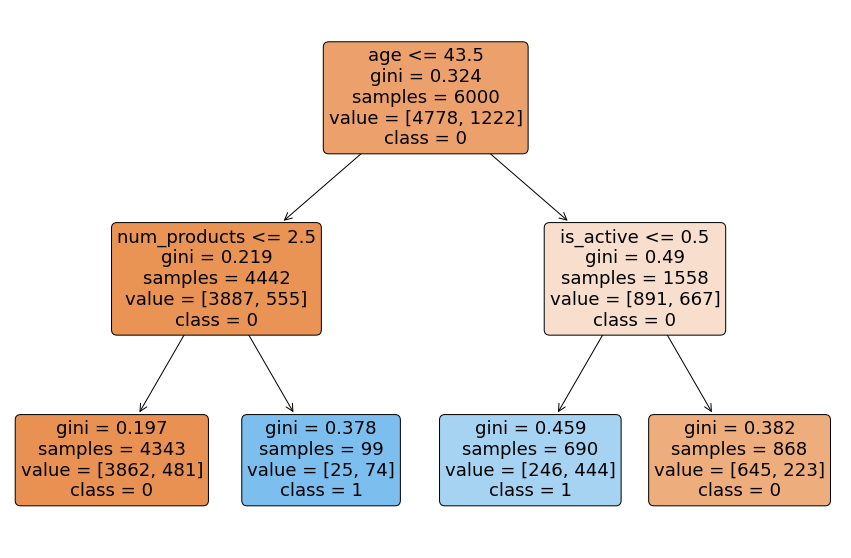

In [34]:
fig = plt.figure(figsize=(15, 10), facecolor='white')
plot_tree(model, 
          feature_names=features_train.columns,
          class_names = ['0', '1'],
          filled=True, impurity=True, 
          rounded=True)

In [35]:
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, valid_predictions) 
    print("Depth:", depth, 'Accuracy:', accuracy)
    x = 'Tree, depth', depth
    results_tab = results_tab.append({'Model' : x, 'Initial' : accuracy} , ignore_index=True)


Depth: 1 Accuracy: 0.796
Depth: 2 Accuracy: 0.835
Depth: 3 Accuracy: 0.84
Depth: 4 Accuracy: 0.849
Depth: 5 Accuracy: 0.8575
Depth: 6 Accuracy: 0.86
Depth: 7 Accuracy: 0.859
Depth: 8 Accuracy: 0.8555
Depth: 9 Accuracy: 0.8445
Depth: 10 Accuracy: 0.8405
Depth: 11 Accuracy: 0.834
Depth: 12 Accuracy: 0.8265
Depth: 13 Accuracy: 0.825
Depth: 14 Accuracy: 0.812
Depth: 15 Accuracy: 0.8085
Depth: 16 Accuracy: 0.8075
Depth: 17 Accuracy: 0.8085
Depth: 18 Accuracy: 0.8025
Depth: 19 Accuracy: 0.8005
Depth: 20 Accuracy: 0.7995


In [36]:
model = LogisticRegression(random_state=12345, solver='liblinear')  
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid) 
result

0.796

In [37]:
results_tab = results_tab.append({'Model' : "Logistic", 'Initial' : result} , ignore_index=True)

In [38]:
param_grid ={'max_depth': range(1, 10), 'n_estimators':range(1, 20), 'random_state': [12345]}  
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, n_jobs = -1, verbose=5) 
grid.fit(features_train, target_train) 

Fitting 5 folds for each of 171 candidates, totalling 855 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(1, 20),
                         'random_state': [12345]},
             verbose=5)

In [39]:
print(grid.best_params_) 

{'max_depth': 8, 'n_estimators': 19, 'random_state': 12345}


In [40]:
model = RandomForestClassifier(random_state=12345, n_estimators=16, max_depth=7)  
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid) 
result

0.8645

In [41]:
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])

In [42]:
results_tab = results_tab.append({'Model' : "Best random forest", 'Initial' : result} , ignore_index=True)

In [43]:
results_tab

,Model,Initial
0,"(Tree, depth, 1)",0.7960
1,"(Tree, depth, 2)",0.8350
2,"(Tree, depth, 3)",0.8400
3,"(Tree, depth, 4)",0.8490
4,"(Tree, depth, 5)",0.8575
5,"(Tree, depth, 6)",0.8600
6,"(Tree, depth, 7)",0.8590
7,"(Tree, depth, 8)",0.8555
8,"(Tree, depth, 9)",0.8445
9,"(Tree, depth, 10)",0.8405


**Conclusions**

1. A model was built on the initial data. It has a high level of accuracy on the validation set. Best model - random forest (depth 7, trees 6)

2. Indicators of accuracy and recall have been calculated. The model does a good job of highlighting all the people who left, but at the same time it gives a large number of false positives, so we have a lot of unnecessary customers marked as high risk of leaving.

### Exploring imbalances

In [44]:
df.describe()

,credit_score,gender,age,tenure,balance,num_products,has_card,is_active,est_salary,exited,germany,spain
count,10000.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,4.99790,7.648589e+06,1.530200,0.70550,0.515100,1.000902e+07,0.203700,0.250900,0.247700
std,96.653299,0.497932,10.487806,2.76001,6.239740e+06,0.581654,0.45584,0.499797,5.751049e+06,0.402769,0.433553,0.431698
min,350.000000,0.000000,18.000000,0.00000,0.000000e+00,1.000000,0.00000,0.000000,1.158000e+03,0.000000,0.000000,0.000000
25%,584.000000,0.000000,32.000000,3.00000,0.000000e+00,1.000000,0.00000,0.000000,5.100211e+06,0.000000,0.000000,0.000000
50%,652.000000,1.000000,37.000000,5.00000,9.719854e+06,1.000000,1.00000,1.000000,1.001939e+07,0.000000,0.000000,0.000000
75%,718.000000,1.000000,44.000000,7.00000,1.276442e+07,2.000000,1.00000,1.000000,1.493882e+07,0.000000,1.000000,0.000000
max,850.000000,1.000000,92.000000,10.00000,2.508981e+07,4.000000,1.00000,1.000000,1.999925e+07,1.000000,1.000000,1.000000


In [45]:
df.groupby('num_products')['gender'].count()

num_products
1    5084
2    4590
3     266
4      60
Name: gender, dtype: int64

In [46]:
df.groupby('germany')['gender'].count()/len(df)*100

germany
0    74.91
1    25.09
Name: gender, dtype: float64

In [47]:
df.groupby('spain')['gender'].count()/len(df)*100

spain
0    75.23
1    24.77
Name: gender, dtype: float64

In [48]:
df.query('spain==0 & germany==0')['gender'].count()/len(df)*100

50.13999999999999

In [49]:
df.groupby('exited')['gender'].count()

exited
0    7963
1    2037
Name: gender, dtype: int64

1. num_products - not many people with 3 and 4 products
2. not many who do not have a card, but probably not important
3. There is more records from France (50/25/25), non-critical
4. there are not enough of those who left, it is still worth raising, given that the target variable

In [50]:
results_tab.sort_values('Initial')

,Model,Initial
0,"(Tree, depth, 1)",0.7960
20,Logistic,0.7960
19,"(Tree, depth, 20)",0.7995
18,"(Tree, depth, 19)",0.8005
17,"(Tree, depth, 18)",0.8025
15,"(Tree, depth, 16)",0.8075
16,"(Tree, depth, 17)",0.8085
14,"(Tree, depth, 15)",0.8085
13,"(Tree, depth, 14)",0.8120
12,"(Tree, depth, 13)",0.8250


**Conclusions**

1. The initial model was built. They have a high level of accuracy on the validation set. Best model - random forest (depth 7, trees 6)

Simple tree model, which has almost the same accuracy, could be better as it is easier to interpret.

2. The model does a good job of highlighting exiting customers, but gives a lot of false positive results

3. Several imbalances were found in the data - by the number of products, as well as by the target variable. It was decided to correct these imbalances, then compare the results of the original models and the models for the modified sample.

### Treating imbalance

#### 1st try

We increase the proportion of people who have 3-4 products

In [51]:
df_majority = df.query('num_products != 4')
df_minority = df.query('num_products == 4')

In [52]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=(4590+5084)//2,    
                                 random_state=12345) 

In [53]:
df_up = pd.concat([df_majority, df_minority_upsampled])
df_up = shuffle(df_up, random_state=12345)

In [54]:
df_majority = df_up.query('num_products != 3')
df_minority = df_up.query('num_products == 3')

In [55]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=(4590+5084)//2,    
                                 random_state=12345) 

In [56]:
df_up = pd.concat([df_majority, df_minority_upsampled])
df_up = shuffle(df_up, random_state=12345)

In [57]:
df_up.groupby('num_products')['gender'].count()

num_products
1    5084
2    4590
3    4837
4    4837
Name: gender, dtype: int64

We equalize the samples of people who left with those who stayed

In [58]:
df_majority = df_up.query('exited != 1')
df_minority = df_up.query('exited == 1')

In [59]:
df1

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain
0,619,0.0,42,2.0,0.00,1,1,1,101348.88,1,0,0
1,608,0.0,41,1.0,83807.86,1,0,1,112542.58,0,0,1
2,502,0.0,42,8.0,159660.80,3,1,0,113931.57,1,0,0
3,699,0.0,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,0.0,43,2.0,125510.82,1,1,1,79084.10,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1.0,39,5.0,0.00,2,1,0,96270.64,0,0,0
9996,516,1.0,35,10.0,57369.61,1,1,1,101699.77,0,0,0
9997,709,0.0,36,7.0,0.00,1,0,1,42085.58,1,0,0
9998,772,1.0,42,3.0,75075.31,2,1,0,92888.52,1,1,0


In [60]:
def upsample(df, parametr, repeat):
    print()
    df_zero = df.query('{} == 0'.format(parametr))
    df_one = df.query('{} == 1'.format(parametr))

    df_upsampled = pd.concat([df_zero] + [df_one] * repeat)
    
    df_upsampled = shuffle(
        df_upsampled, random_state=12345)
    
    return df_upsampled

In [61]:
print(df1.groupby('Exited')['CreditScore'].count())
df1_up = upsample(df1, 'Exited', 3)
print(df1_up.groupby('Exited')['CreditScore'].count())

Exited
0    7963
1    2037
Name: CreditScore, dtype: int64

Exited
0    7963
1    6111
Name: CreditScore, dtype: int64


In [62]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),    
                                 random_state=12345) 

In [63]:
df_up = pd.concat([df_majority, df_minority_upsampled])
df_up = shuffle(df_up, random_state=12345)

In [64]:
df_up.groupby('exited')['gender'].count()

exited
0    8755
1    8755
Name: gender, dtype: int64

In [65]:
df_up.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17510 entries, 3227 to 8531
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   credit_score  17510 non-null  int64
 1   gender        17510 non-null  int64
 2   age           17510 non-null  int64
 3   tenure        17510 non-null  int64
 4   balance       17510 non-null  int64
 5   num_products  17510 non-null  int64
 6   has_card      17510 non-null  int64
 7   is_active     17510 non-null  int64
 8   est_salary    17510 non-null  int64
 9   exited        17510 non-null  int64
 10  germany       17510 non-null  uint8
 11  spain         17510 non-null  uint8
dtypes: int64(10), uint8(2)
memory usage: 1.5 MB


#### 2nd try

In [66]:
df_majority = df.query('exited != 1')
df_minority = df.query('exited == 1')

In [67]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),    
                                 random_state=12345) 

In [68]:
df_up1 = pd.concat([df_majority, df_minority_upsampled])
df_up = shuffle(df_up, random_state=12345)

In [69]:
df_up1.groupby('exited')['gender'].count()

exited
0    7963
1    7963
Name: gender, dtype: int64

**Conclusions**

Initially, 2 indicators were selected, where it was decided to make the sample more uniform:
1. Number of observations where the client uses 3-4 products. For them, the number of observations is increased to the average number of observations of customers with 1-2 products
2. The number of observations where the client refused the services of the bank. According to them, the number of observations was increased to 50% of the entire sample.


**Conclusions 2**

3. Testing the model did not show very good results, so it was decided to return to stage 3 and add code under the "2nd stage" block
4. A possible reason for the problems with the initial try with the imbalance was the increase in the proportion of customers with 3-4 products. In the 2nd try with the imbalance, only the number of observations where the client refused the bank's services was brought to 50% of the entire sample


Now in the testing part of the work there are 3 selections:
1. df - original
2. df_up - the sample where the 1st try with the imbalance was made
3. df_up1 - sample where the 2nd try with the imbalance was made

## 2nd step of Model building and testing

### Testing the model on the improved sample (1st try)

We check the df_up sample for the same models as the original sample

In [70]:
results_tab1 = pd.DataFrame()
results_tab1 = results_tab1.reindex(columns = ('Model', '1st try treating imbalance'))        

In [71]:
df_train, df_valid = train_test_split(df_up, test_size=0.4, random_state=12345,
                                      stratify=df_up['exited']) 
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345,
                                     stratify=df_valid['exited']) 

In [72]:
display(df_train.describe())
display(df_test.describe())
display(df_valid.describe())

,credit_score,gender,age,tenure,balance,num_products,has_card,is_active,est_salary,exited,germany,spain
count,10506.000000,10506.000000,10506.000000,10506.000000,1.050600e+04,10506.000000,10506.000000,10506.000000,1.050600e+04,10506.000000,10506.000000,10506.000000
mean,650.387874,0.488197,41.334856,5.108795,8.002114e+06,2.416334,0.702741,0.495812,1.026582e+07,0.500000,0.299924,0.220731
std,96.628047,0.499884,10.473720,2.765268,6.175393e+06,1.115208,0.457073,0.500006,5.695185e+06,0.500024,0.458246,0.414759
min,350.000000,0.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,9.007000e+03,0.000000,0.000000,0.000000
25%,586.000000,0.000000,34.000000,3.000000,0.000000e+00,1.000000,0.000000,0.000000,5.642249e+06,0.000000,0.000000,0.000000
50%,649.000000,0.000000,40.000000,5.000000,1.020797e+07,2.000000,1.000000,0.000000,1.047225e+07,0.500000,0.000000,0.000000
75%,714.000000,1.000000,48.000000,7.000000,1.293709e+07,3.000000,1.000000,1.000000,1.496399e+07,1.000000,1.000000,0.000000
max,850.000000,1.000000,92.000000,10.000000,2.508981e+07,4.000000,1.000000,1.000000,1.999925e+07,1.000000,1.000000,1.000000


,credit_score,gender,age,tenure,balance,num_products,has_card,is_active,est_salary,exited,germany,spain
count,3502.000000,3502.000000,3502.00000,3502.000000,3.502000e+03,3502.000000,3502.000000,3502.000000,3.502000e+03,3502.000000,3502.000000,3502.000000
mean,650.834951,0.487436,41.39663,5.067390,7.921445e+06,2.401485,0.701028,0.492005,1.027777e+07,0.500000,0.315534,0.209880
std,97.374146,0.499913,10.71961,2.759838,6.160769e+06,1.120492,0.457873,0.500007,5.776204e+06,0.500071,0.464795,0.407281
min,358.000000,0.000000,18.00000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,1.781900e+04,0.000000,0.000000,0.000000
25%,586.000000,0.000000,34.00000,3.000000,0.000000e+00,1.000000,0.000000,0.000000,5.522265e+06,0.000000,0.000000,0.000000
50%,650.000000,0.000000,40.00000,5.000000,1.015435e+07,2.000000,1.000000,0.000000,1.061747e+07,0.500000,0.000000,0.000000
75%,717.000000,1.000000,48.00000,7.000000,1.285534e+07,3.000000,1.000000,1.000000,1.508352e+07,1.000000,1.000000,0.000000
max,850.000000,1.000000,81.00000,10.000000,2.508981e+07,4.000000,1.000000,1.000000,1.999093e+07,1.000000,1.000000,1.000000


,credit_score,gender,age,tenure,balance,num_products,has_card,is_active,est_salary,exited,germany,spain
count,3502.000000,3502.000000,3502.000000,3502.000000,3.502000e+03,3502.000000,3502.000000,3502.000000,3.502000e+03,3502.000000,3502.000000,3502.000000
mean,651.832096,0.482296,41.176756,5.112222,7.818998e+06,2.416334,0.705026,0.492576,1.029334e+07,0.500000,0.296688,0.216733
std,95.439864,0.499758,10.566847,2.773302,6.243220e+06,1.116338,0.456096,0.500016,5.660002e+06,0.500071,0.456863,0.412078
min,350.000000,0.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,9.627000e+03,0.000000,0.000000,0.000000
25%,589.000000,0.000000,33.000000,3.000000,0.000000e+00,1.000000,0.000000,0.000000,5.836425e+06,0.000000,0.000000,0.000000
50%,651.000000,0.000000,40.000000,5.000000,1.009560e+07,2.000000,1.000000,0.000000,1.047225e+07,0.500000,0.000000,0.000000
75%,713.000000,1.000000,48.000000,7.000000,1.284488e+07,3.000000,1.000000,1.000000,1.488377e+07,1.000000,1.000000,0.000000
max,850.000000,1.000000,85.000000,10.000000,2.508981e+07,4.000000,1.000000,1.000000,1.999707e+07,1.000000,1.000000,1.000000


In [73]:
features_train_up = df_train.drop('exited', axis=1)
target_train_up = df_train['exited']
features_valid_up = df_valid.drop('exited', axis=1)
target_valid_up = df_valid['exited']
features_test_up = df_valid.drop('exited', axis=1)
target_test_up = df_valid['exited']
features_df_up = df_up.drop('exited', axis=1)
target_df_up = df_up['exited']

In [74]:
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train_up, target_train_up)
    valid_predictions = model.predict(features_valid_up)
    accuracy = accuracy_score(target_valid_up, valid_predictions) 
    print("Depth:", depth, 'Accuracy:', accuracy)
    x = 'Tree, depth', depth
    results_tab1 = results_tab1.append({'Model' : x, '1st try treating imbalance' : accuracy} , ignore_index=True)

Depth: 1 Accuracy: 0.8597944031981725
Depth: 2 Accuracy: 0.8597944031981725
Depth: 3 Accuracy: 0.8686464877213022
Depth: 4 Accuracy: 0.892632781267847
Depth: 5 Accuracy: 0.9009137635636779
Depth: 6 Accuracy: 0.905197030268418
Depth: 7 Accuracy: 0.9129069103369503
Depth: 8 Accuracy: 0.9177612792689891
Depth: 9 Accuracy: 0.922615648201028
Depth: 10 Accuracy: 0.9246145059965734
Depth: 11 Accuracy: 0.9231867504283267
Depth: 12 Accuracy: 0.9246145059965734
Depth: 13 Accuracy: 0.924328954882924
Depth: 14 Accuracy: 0.924328954882924
Depth: 15 Accuracy: 0.9220445459737293
Depth: 16 Accuracy: 0.9211878926327812
Depth: 17 Accuracy: 0.9263278126784694
Depth: 18 Accuracy: 0.920902341519132
Depth: 19 Accuracy: 0.9229011993146773
Depth: 20 Accuracy: 0.924328954882924


In [75]:
model = LogisticRegression(random_state=12345, solver='liblinear')  
model.fit(features_train_up, target_train_up)
result = model.score(features_valid_up, target_valid_up) 
result

0.5936607652769845

In [76]:
results_tab1 = results_tab1.append({'Model' : "Logistic", '1st try treating imbalance' : result} , ignore_index=True)

In [77]:
param_grid ={'max_depth': range(1, 10), 'n_estimators':range(1, 20), 'random_state': [12345]}  
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, n_jobs = -1, verbose=5) 
grid.fit(features_train_up, target_train_up) 

Fitting 5 folds for each of 171 candidates, totalling 855 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(1, 20),
                         'random_state': [12345]},
             verbose=5)

In [78]:
print(grid.best_params_) 

{'max_depth': 9, 'n_estimators': 16, 'random_state': 12345}


In [79]:
model = RandomForestClassifier(random_state=12345, n_estimators=16, max_depth=9)  
model.fit(features_train_up, target_train_up)
result = model.score(features_valid_up, target_valid_up) 
result

0.9314677327241576

In [80]:
results_tab1 = results_tab1.append({'Model' : "Best random forest", '1st try treating imbalance' : result} , ignore_index=True)

Comparison of models over 2 samples shows higher accuracy on the validation set for all types of models, except for the logistic one.

In [81]:
results_tab = results_tab.merge(results_tab1, left_on='Model', right_on='Model')
results_tab

,Model,Initial,1st try treating imbalance
0,"(Tree, depth, 1)",0.7960,0.859794
1,"(Tree, depth, 2)",0.8350,0.859794
2,"(Tree, depth, 3)",0.8400,0.868646
3,"(Tree, depth, 4)",0.8490,0.892633
4,"(Tree, depth, 5)",0.8575,0.900914
5,"(Tree, depth, 6)",0.8600,0.905197
6,"(Tree, depth, 7)",0.8590,0.912907
7,"(Tree, depth, 8)",0.8555,0.917761
8,"(Tree, depth, 9)",0.8445,0.922616
9,"(Tree, depth, 10)",0.8405,0.924615


In [82]:
features_train_valid_up = pd.concat([features_train_up, features_valid_up])
target_train_valid_up = pd.concat([target_train_up, target_valid_up])

The best models were taken for each sample (in both cases, the forest)
They are retrained taking into account the combined validation and training set

The accuracy of the corrected sample model is higher

In [83]:
model_best_scaled = RandomForestClassifier(random_state=12345, 
                                           n_estimators=16, max_depth=9)  
model_best_scaled.fit(features_train_valid_up, target_train_valid_up)
result = model_best_scaled.score(features_test_up, target_test_up) 
result

0.9380354083380925

In [84]:
model_best_unscaled = RandomForestClassifier(random_state=12345, 
                                             n_estimators=16, max_depth=9)  
model_best_unscaled.fit(features_train_valid, target_train_valid)
result = model_best_unscaled.score(features_test, target_test) 
print(result)

0.8945


The same can be said about the indicators f1, recall and precision.
The original model had good recall but poor accuracy. That means it was marking to many people as high risk of leaving

In [85]:
print('model_best_scaled')
print('recall_score:',recall_score(model_best_scaled.predict(features_test_up), target_test_up))
print('precision_score:',precision_score(model_best_scaled.predict(features_test_up), target_test_up))
print('f1_score:',f1_score(model_best_scaled.predict(features_test_up), target_test_up))

model_best_scaled
recall_score: 0.9860583016476553
precision_score: 0.8886350656767561
f1_score: 0.9348152598377891


In [86]:
print('model_best_unscaled')
print('recall_score:',recall_score(model_best_unscaled.predict(features_test), target_test))
print('precision_score:',precision_score(model_best_unscaled.predict(features_test), target_test))
print('f1_score:',f1_score(model_best_unscaled.predict(features_test), target_test))

model_best_unscaled
recall_score: 0.8862745098039215
precision_score: 0.553921568627451
f1_score: 0.6817496229260935


**BUT!**

The purpose of the model is not to predict upscaled data, but to work on real data. Therefore, it is necessary to compare its recall / precision on the original test ones.
And here everything is worse than the model on the initial data.

It has become even better at highlighting those who leave, but at the cost of accuracy - that is, a lot of false positives.

In [87]:
print('model_best_scaled on initial test data')
print('recall_score:',recall_score(model_best_scaled.predict(features_test), target_test))
print('precision_score:',precision_score(model_best_scaled.predict(features_test), target_test))
print('f1_score:',f1_score(model_best_scaled.predict(features_test), target_test))

model_best_scaled on initial test data
recall_score: 0.8909952606635071
precision_score: 0.46078431372549017
f1_score: 0.6074313408723747


### Testing the model on the improved sample (2nd try)

In [88]:
results_tab1 = pd.DataFrame()
results_tab1 = results_tab1.reindex(columns = ('Model', '2nd try treating imbalance'))        

In [89]:
df_train, df_valid = train_test_split(df_up1, test_size=0.4, random_state=12345,
                                      stratify=df_up1['exited']) 
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345,
                                     stratify=df_valid['exited']) 

In [90]:
features_train_up1 = df_train.drop('exited', axis=1)
target_train_up1 = df_train['exited']
features_valid_up1 = df_valid.drop('exited', axis=1)
target_valid_up1 = df_valid['exited']
features_test_up1 = df_valid.drop('exited', axis=1)
target_test_up1 = df_valid['exited']
features_df_up1 = df_up.drop('exited', axis=1)
target_df_up1 = df_up['exited']

In [91]:
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train_up1, target_train_up1)
    valid_predictions = model.predict(features_valid_up1)
    accuracy = accuracy_score(target_valid_up1, valid_predictions) 
    print("Depth:", depth, 'Accuracy:', accuracy)
    x = 'Tree, depth', depth
    results_tab1 = results_tab1.append({'Model' : x, '2nd try treating imbalance' : accuracy} , ignore_index=True)

Depth: 1 Accuracy: 0.695447409733124
Depth: 2 Accuracy: 0.7142857142857143
Depth: 3 Accuracy: 0.7237048665620094
Depth: 4 Accuracy: 0.7368916797488226
Depth: 5 Accuracy: 0.7708006279434851
Depth: 6 Accuracy: 0.7748822605965463
Depth: 7 Accuracy: 0.7843014128728415
Depth: 8 Accuracy: 0.7896389324960753
Depth: 9 Accuracy: 0.8043956043956044
Depth: 10 Accuracy: 0.8204081632653061
Depth: 11 Accuracy: 0.8301412872841444
Depth: 12 Accuracy: 0.8401883830455259
Depth: 13 Accuracy: 0.8521193092621664
Depth: 14 Accuracy: 0.8627943485086342
Depth: 15 Accuracy: 0.875353218210361
Depth: 16 Accuracy: 0.8869701726844584
Depth: 17 Accuracy: 0.8938775510204081
Depth: 18 Accuracy: 0.8976452119309262
Depth: 19 Accuracy: 0.8951334379905809
Depth: 20 Accuracy: 0.9007849293563579


In [92]:
model = LogisticRegression(random_state=12345, solver='liblinear')  
model.fit(features_train_up1, target_train_up1)
result = model.score(features_valid_up1, target_valid_up1) 
result

0.5673469387755102

In [93]:
results_tab1 = results_tab1.append({'Model' : "Logistic",
                                    '2nd try treating imbalance' : result} , 
                                   ignore_index=True)

In [94]:
param_grid ={'max_depth': range(1, 20), 'n_estimators':range(1, 10), 'random_state': [12345]}  
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, n_jobs = -1, verbose=5) 
grid.fit(features_train_up1, target_train_up1) 

Fitting 5 folds for each of 171 candidates, totalling 855 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 20),
                         'n_estimators': range(1, 10),
                         'random_state': [12345]},
             verbose=5)

In [95]:
print(grid.best_params_) 

{'max_depth': 19, 'n_estimators': 8, 'random_state': 12345}


In [96]:
model = RandomForestClassifier(random_state=12345, n_estimators=8, max_depth=17)  
model.fit(features_train_up1, target_train_up1)
result = model.score(features_valid_up1, target_valid_up1) 
result

0.9252747252747253

In [97]:
results_tab1 = results_tab1.append({'Model' : "Best random forest", '2nd try treating imbalance' : result} , ignore_index=True)

In [98]:
results_tab = results_tab.merge(results_tab1, left_on='Model', right_on='Model')

In [99]:
results_tab.sort_values('2nd try treating imbalance', ascending=False)

,Model,Initial,1st try treating imbalance,2nd try treating imbalance
21,Best random forest,0.8645,0.931468,0.925275
19,"(Tree, depth, 20)",0.7995,0.924329,0.900785
17,"(Tree, depth, 18)",0.8025,0.920902,0.897645
18,"(Tree, depth, 19)",0.8005,0.922901,0.895133
16,"(Tree, depth, 17)",0.8085,0.926328,0.893878
15,"(Tree, depth, 16)",0.8075,0.921188,0.886970
14,"(Tree, depth, 15)",0.8085,0.922045,0.875353
13,"(Tree, depth, 14)",0.8120,0.924329,0.862794
12,"(Tree, depth, 13)",0.8250,0.924329,0.852119
11,"(Tree, depth, 12)",0.8265,0.924615,0.840188


Best Model - Random Forest

In [100]:
features_train_valid_up1 = pd.concat([features_train_up1, features_valid_up1])
target_train_valid_up1 = pd.concat([target_train_up1, target_valid_up1])
model_best_scaled_v2 = RandomForestClassifier(random_state=12345, 
                                              n_estimators=8, max_depth=17)  
model_best_scaled_v2.fit(features_train_valid_up1, target_train_valid_up1)
result = model_best_unscaled.score(features_test_up1, target_test_up1) 
print(result)

0.7306122448979592


In [101]:
print('model_best_scaled_2nd try upscaled test')
print('recall_score:',recall_score(model_best_scaled_v2.predict(features_test_up1), target_test_up1))
print('precision_score:',precision_score(model_best_scaled_v2.predict(features_test_up1), target_test_up1))
print('f1_score:',f1_score(model_best_scaled_v2.predict(features_test_up1), target_test_up1))

model_best_scaled_2nd try upscaled test
recall_score: 0.9906191369606003
precision_score: 0.9949748743718593
f1_score: 0.9927922281416484


In [102]:
print('model_best_scaled_2nd try initial data')
print('recall_score:',recall_score(model_best_scaled.predict(features_test), target_test))
print('precision_score:',precision_score(model_best_scaled.predict(features_test), target_test))
print('f1_score:',f1_score(model_best_scaled.predict(features_test), target_test))

model_best_scaled_2nd try initial data
recall_score: 0.8909952606635071
precision_score: 0.46078431372549017
f1_score: 0.6074313408723747


The model on the original data remained the best. Perhaps, since the model gave a lot of false positive results, it was worth increasing the proportion of the remaining ones??

In [103]:
probabilities_test = model_best_unscaled.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test) 
auc_roc

0.9314710808946695

In [104]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

In [105]:
probabilities_test_up = model_best_scaled.predict_proba(features_test)
probabilities_one_test_up = probabilities_test_up[:, 1]
fpr_up, tpr_up, thresholds = roc_curve(target_test, probabilities_one_test_up) 

In [106]:
probabilities_test_up1 = model_best_scaled_v2.predict_proba(features_test)
probabilities_one_test_up1 = probabilities_test_up1[:, 1]
fpr_up1, tpr_up1, thresholds = roc_curve(target_test, probabilities_one_test_up1) 

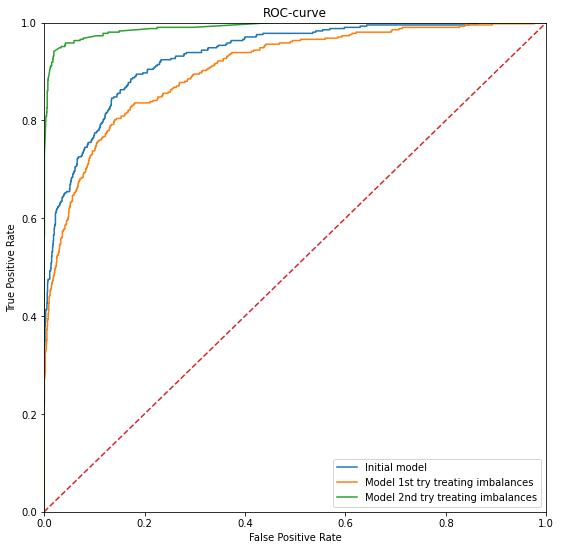

In [107]:
fig, axes = plt.subplots(facecolor='white', figsize=(9,9))

plt.plot(fpr, tpr)
plt.plot(fpr_up, tpr_up)
plt.plot(fpr_up1, tpr_up1)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(['Initial model','Model 1st try treating imbalances','Model 2nd try treating imbalances'])

**Conclusions**

1. The data was processed and brought into the format required for the machine learning
2. Several models were taken: tree, logistic and forest. For 1 and 3 different parameters were considered
3. There were 2 indicators that we can treat in the sample for imbalances: the number of products and the number of people who left. The 1st try in the sample led to better results (when compared to the changed validation and test set), but when working with the original data, it turned out to be worse
4. 2 try to treat imbalances was made, where the upscale was made only for those who left - but the results were no better. So, in fact, the original model on the initial sample turned out to be better and corresponded to the required parameters f1